In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression

/home/hv270/platelets/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


# Mark sub-cohorts of PFC cohort

In [2]:
sys_phen = load_sys_phenotypes(data_dir)

602 candidates summary files
Initially 1068 rows, 643 unique IDs
Finally 642 rows, 642 unique IDs


In [3]:
sys_phen["time_col"] = pd.to_datetime(sys_phen["Date"],format="%d/%m/%Y")
sys_phen.sort_values("time_col",inplace=True)

In [4]:
sys_phen.head()

,Nickname,Analyzer ID,Date,Time,Rack,ID,Sample Inf.,Order Type,Reception Date,Measurement Mode,...,IG%/M,NEUT#&/M,NEUT%&/M,NE-SSC/M,NE-SFL/M,NE-FSC/M,IP SUS(RBC)Iron Deficiency?,HCT/M,RDW-CV/M,time_col
840,XN-1000-1-A,XN-20^12829,12/01/2016,13:28:07,6,C0WX8R,B,Initial,12/01/2016 13:25:58,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12
844,XN-1000-1-A,XN-20^12829,12/01/2016,10:05:38,2,C0WX14,B,Initial,12/01/2016 10:03:29,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12
842,XN-1000-1-A,XN-20^12829,12/01/2016,11:29:19,4,C0WX6V,B,Initial,12/01/2016 11:27:10,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12
843,XN-1000-1-A,XN-20^12829,12/01/2016,10:44:17,3,C0WX4Z,B,Initial,12/01/2016 10:42:08,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12
841,XN-1000-1-A,XN-20^12829,12/01/2016,12:03:07,5,C0WX7T,B,Initial,12/01/2016 12:00:58,WB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12


In [5]:
sys_features = sys_phen.set_index("ID")[SYS_FEATURES]
assert sys_features.shape[0] == sys_phen.ID.nunique()

In [6]:
sys_features["IPF"] = np.log10(sys_features["IPF"])

In [7]:
sys_features.head()

,PLT,MPV,PDW,PCT,IPF
ID,,,,,
C0WX8R,265.0,10.9,12.9,0.28,0.633468
C0WX14,281.0,9.3,9.8,0.24,0.342423
C0WX6V,281.0,10.1,11.2,0.27,0.531479
C0WX4Z,259.0,10.2,11.8,0.25,0.361728
C0WX7T,273.0,11.1,13.7,0.29,0.505150


In [8]:
X = sys_features.copy()
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [9]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=40).fit(
    X.values
)

4 BKPS


<Figure size 720x288 with 0 Axes>

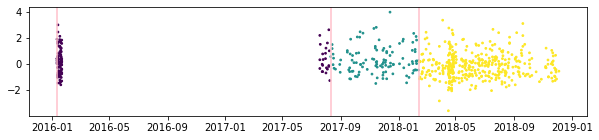

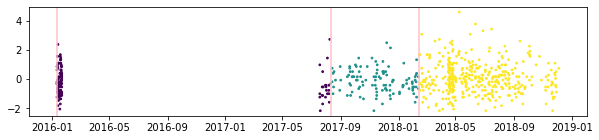

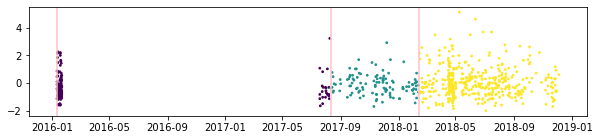

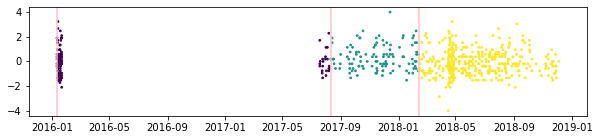

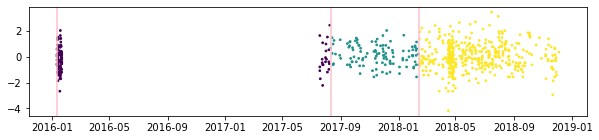

In [10]:
bkps = algo_c.predict(pen=1.6)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

sys_features["cohort"] = 0
sys_features["rank"] = np.arange(sys_features.shape[0])
for b in bkps[1:]:
    sys_features.loc[sys_features["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(sys_phen.time_col,X.iloc[:,i],s=3,c=sys_features.cohort)
    for b in bkps[:-1]:
        plt.axvline(sys_phen.time_col.iloc[b],c="pink")

# Mark sub-cohorts of INT cohort

In [11]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
Removing samples with less than 10 measurements per day
(30725, 782)


In [12]:
int_phen["IPF"] = np.log10(int_phen["IPF"])

In [13]:
int_phen.sort_values(["machine","DateTime"],inplace=True)
int_features = int_phen.set_index("SampleNo")[SYS_FEATURES]

In [14]:
X = int_features.copy()
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [15]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=300).fit(
    X.values
)
bkps = algo_c.predict(pen=1.6)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

29 BKPS


<Figure size 720x288 with 0 Axes>

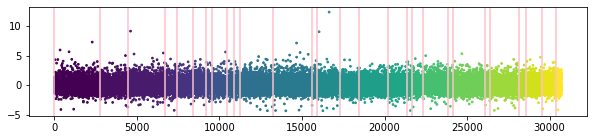

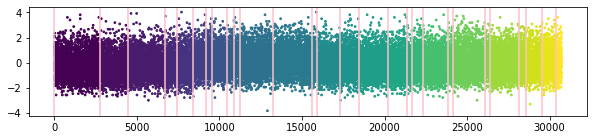

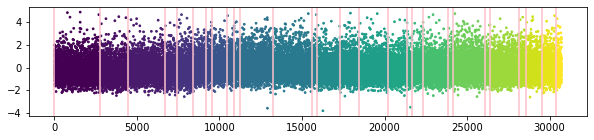

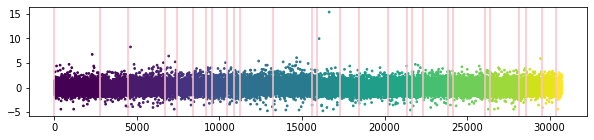

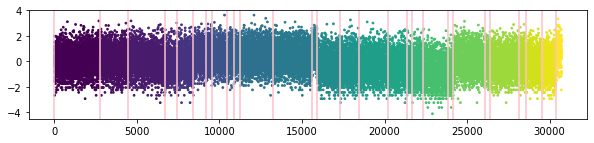

In [16]:
int_features["cohort"] = sys_features.cohort.max() + 1
int_features["rank"] = np.arange(int_features.shape[0])
for b in bkps[1:]:
    int_features.loc[int_features["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(int_features["rank"],X.iloc[:,i],s=3,c=int_features.cohort,s=.1)
    for b in bkps[:-1]:
        plt.axvline(int_features["rank"].iloc[b],c="pink")

# age & sex

In [17]:
sys_info, int_info = get_ages_sex()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
Removing samples with less than 10 measurements per day
(30725, 782)


In [18]:
sys_info.head()

,SEX,AGE
SAMPLE_ID,,
C0WX14,2,67.0
C0WX4Z,2,63.0
C0WX6V,2,64.0
C0WX7T,2,70.0
C0WX8R,2,71.0


In [19]:
int_info.head()

,SEX,AGE
SampleNo,,
INT_116_6580100,1,58.8
INT_116_6580000,2,22.6
INT_116_4555900,2,59.4
INT_116_4555800,2,21.3
INT_116_4556000,1,49.3


# Gather cohort + features + info

In [67]:
# merge sys
sys = pd.merge(sys_features, sys_info,left_index=True,right_index=True,how="inner")
print("%d samples in Sysmex cohort" % sys.shape[0])
sys.head()

635 samples in Sysmex cohort


,PLT,MPV,PDW,PCT,IPF,cohort,rank,SEX,AGE
C0WX8R,265.0,10.9,12.9,0.28,0.633468,0,0,2,71.0
C0WX14,281.0,9.3,9.8,0.24,0.342423,0,1,2,67.0
C0WX6V,281.0,10.1,11.2,0.27,0.531479,0,2,2,64.0
C0WX4Z,259.0,10.2,11.8,0.25,0.361728,0,3,2,63.0
C0WX7T,273.0,11.1,13.7,0.29,0.505150,0,4,2,70.0


In [68]:
# merge int
int_ = pd.merge(int_features, int_info,left_index=True,right_index=True,how="inner")
int_["rank"] += sys["rank"].max() + 1
print("%d samples in Interval cohort" % int_.shape[0])
int_.head()

30725 samples in Interval cohort


,PLT,MPV,PDW,PCT,IPF,cohort,rank,SEX,AGE
SampleNo,,,,,,,,,
INT_116_2126200,220.0,11.4,14.2,0.27,0.462398,3,642,1,20.8
INT_116_2126400,190.0,13.5,18.8,0.28,0.755875,3,643,1,28.5
INT_116_146000,333.0,10.9,12.7,0.36,0.579784,3,644,2,56.4
INT_116_146200,212.0,12.7,15.7,0.27,0.748188,3,645,2,61.5
INT_116_2126800,200.0,12.6,17.6,0.27,0.908485,3,646,1,34.4


In [69]:
all_ = pd.concat([sys,int_],axis=0)
all_.head()

,PLT,MPV,PDW,PCT,IPF,cohort,rank,SEX,AGE
C0WX8R,265.0,10.9,12.9,0.28,0.633468,0,0,2,71.0
C0WX14,281.0,9.3,9.8,0.24,0.342423,0,1,2,67.0
C0WX6V,281.0,10.1,11.2,0.27,0.531479,0,2,2,64.0
C0WX4Z,259.0,10.2,11.8,0.25,0.361728,0,3,2,63.0
C0WX7T,273.0,11.1,13.7,0.29,0.505150,0,4,2,70.0


In [70]:
cohort_cols = pd.get_dummies(all_["cohort"],drop_first=True)

In [91]:
X = pd.concat([all_[["SEX","AGE"]],cohort_cols],axis=1).copy()
Y = all_[SYS_FEATURES].copy()

In [92]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,Y)
coef = lm.coef_
cohort_coef = coef[:,2:]
print(cohort_coef.shape)

(5, 30)


In [93]:
def correlation(X1,X2):
    return ((X1-X1.mean(axis=0)) / X1.std(axis=0)).T @ ((X2-X2.mean(axis=0)) / X2.std(axis=0)) / (X1.shape[0])

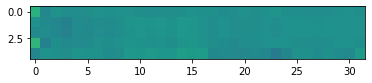

In [94]:
plt.imshow(correlation(X,Y).T,vmin=-1,vmax=1)

In [95]:
for i in range(np.max(all_.cohort)):
    Y.loc[all_.cohort == i+1] -= cohort_coef[:,i]

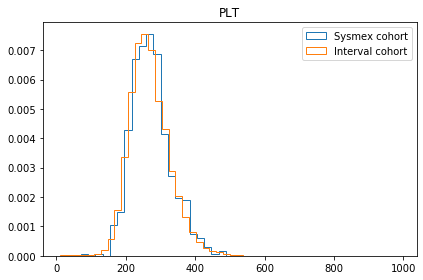

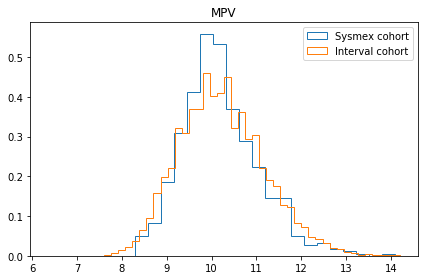

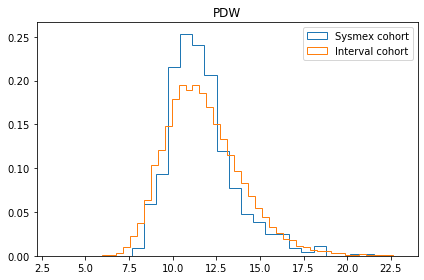

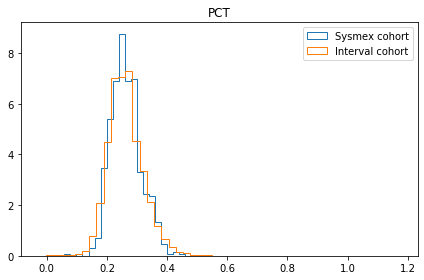

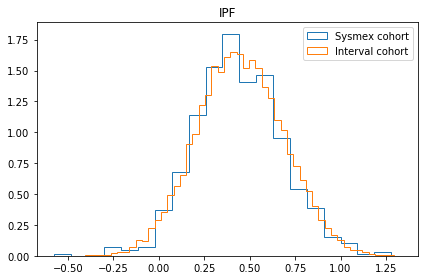

In [96]:
for col in SYS_FEATURES:
    plt.figure()
    plt.hist(Y.loc[all_.cohort.isin(sys.cohort.unique().tolist()),col],density=True,bins=20,histtype="step",label="Sysmex cohort")
    plt.hist(Y.loc[~all_.cohort.isin(sys.cohort.unique().tolist()),col],density=True,bins=50,histtype="step",label="Interval cohort")
    plt.title(col)
    plt.legend()
    plt.tight_layout()

# Export

In [97]:
# Sysmex features to be used later
all_[SYS_FEATURES].to_csv("%s/processed/sysmex_features_unadjusted.csv" % data_dir,index=True)
Y[SYS_FEATURES].to_csv("%s/processed/sysmex_features.csv" % data_dir,index=True)
# int_phen, for Intrument and Filename
int_phen[["SampleNo","Instrument","FileName"]].to_csv("%s/processed/interval_instrument_filename.csv" % data_dir,index=True)

In [98]:
info = all_.copy()
info[SYS_FEATURES] = Y[SYS_FEATURES]

In [107]:
info.to_csv("%s/processed/adj_sysmex_features_age_sex.csv" % data_dir,index=True)

In [99]:
from scipy.stats import pearsonr

In [100]:
info.head()

,PLT,MPV,PDW,PCT,IPF,cohort,rank,SEX,AGE
C0WX8R,265.0,10.9,12.9,0.28,0.633468,0,0,2,71.0
C0WX14,281.0,9.3,9.8,0.24,0.342423,0,1,2,67.0
C0WX6V,281.0,10.1,11.2,0.27,0.531479,0,2,2,64.0
C0WX4Z,259.0,10.2,11.8,0.25,0.361728,0,3,2,63.0
C0WX7T,273.0,11.1,13.7,0.29,0.505150,0,4,2,70.0


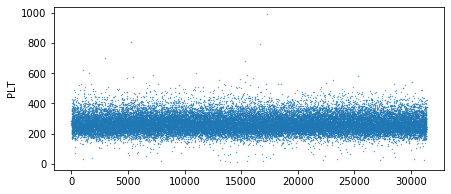

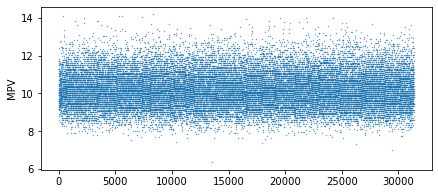

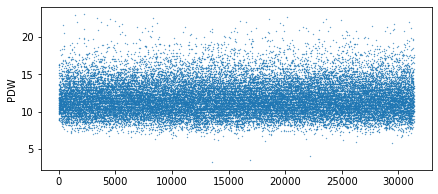

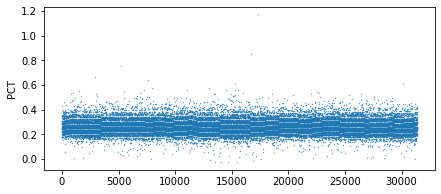

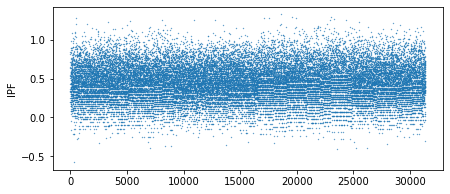

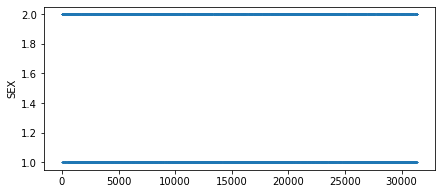

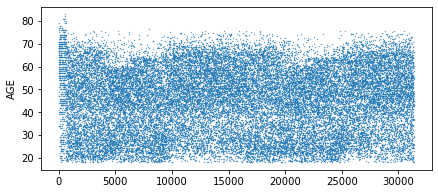

In [101]:
for c in info.columns:
    if c in ["rank","cohort","rank_100"]: continue
    plt.figure(figsize=(7,3))
    plt.scatter(info["rank"],info[c],s=.1)
    plt.ylabel(c)

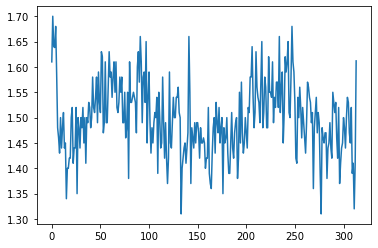

In [102]:
info["rank_100"] = info["rank"] // 100
plt.plot(info.groupby("rank_100")["SEX"].mean())

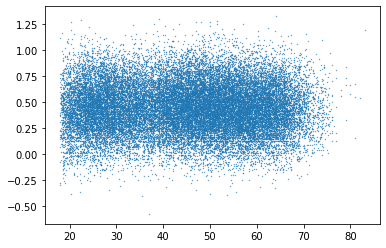

In [103]:
plt.scatter(info.AGE,info.IPF,s=.1)